In [ ]:
from __future__ import print_function, absolute_import, with_statement
# from IPython import display as ipythondisplay
import tensorflow as tf
# tf.enable_eager_execution()

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import os

# Import plot utilities
from dl_utils import myplot

# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
  tpu = None
  
# Select appropriate distribution strategy
if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
  strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
print("Number of accelerators: ", strategy.num_replicas_in_sync)


In [ ]:
import numpy as np

TRAIN_BUF = 50000
TEST_BUF = 10000
BATCH_SIZE = 2000

# Setup jpeg noise function
jpeg_params = dict(min_jpeg_quality=25, 
                   max_jpeg_quality=50)

def add_jpeg_noise(img, jpeg_quality=25):
  jpeg_quality = jpeg_quality
  img_corrupt = tf.image.adjust_jpeg_quality(img, jpeg_quality)
  img_corrupt = tf.clip_by_value(img_corrupt, 0, 1)
  return img_corrupt

def random_jpeg_noise(img, min_jpeg_quality=25, max_jpeg_quality=50):
  img_corrupt = tf.image.random_jpeg_quality(img, **jpeg_params)
  img_corrupt = tf.clip_by_value(img_corrupt, 0, 1)
  return img_corrupt

def add_random_noise(img):
  noise_factor = 0.1
  img_corrupt = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape[:-1])
  img_corrupt = np.clip(img_corrupt, 0, 1)
  return img_corrupt

def prepare_image_dataset(x):
  x = tf.cast(x, tf.float32) / 255
  #x = x.astype('float32') / 255
  return x

def cv2_jpeg_encode(img):
  jpeg_quality = 10
  img = np.array(img)
  if img.max() <= 1:
    img = np.multiply(img, 255)
  img = cv2.imencode('.jpg', img, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])[1]
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  return img

def cv2_jpeg(img_in):
  import tempfile
  import os
  tmp_dir = tempfile.gettempdir()
  img_dir = os.path.join(tmp_dir, "images")
  img_path = os.path.join(img_dir, "tmp.jpg")
  if not os.path.exists(img_dir):
    os.mkdir(img_dir)
  jpeg_quality = 10
  img = img_in.copy()
  img = np.array(img)
  if img.max() <= 1:
    img = np.multiply(img, 255)
  cv2.imwrite(img_path, img, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def resize_image_dataset(img, size=(64,64)):
  size = size
  #method = tf.image.ResizeMethod.BICUBIC
  img_resize = tf.image.resize_images(img, size)#, method=method)
  #img_resize = tf.image.resize_bicubic(img, size)
  return img_resize

# Load CIFAR10 Images
def cifar10_dataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  print("Import: Dtype: ", x_train.dtype, " Training Dataset Dimensions: ", x_train.shape, "Training Dataset Max: ", x_train.max())
  print("Import: Dtype: ", x_train.dtype, "Testing Dataset Dimensions: ", x_test.shape, "Testing Dataset Max: ", x_test.max())
  x_train_corrupt = x_train.copy()
  x_test_corrupt = x_test.copy()
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.
  x_train_corrupt = x_train_corrupt.astype('float32') / 255.
  x_test_corrupt = x_test_corrupt.astype('float32') / 255.
  
  for img_train in x_train_corrupt:
#     img_train = add_jpeg_noise(img_train)
    img_train = cv2_jpeg(img_train)
  for img_test in x_test_corrupt:
#     img_test = add_jpeg_noise(img_test)
    img_test = cv2_jpeg(img_test)
    
  return (x_train, x_train_corrupt), (x_test, x_test_corrupt)
  
def prepare_mnist_features_and_labels(x, y):
  x = tf.cast(x, tf.float32) / 255.0
  y = tf.cast(y, tf.int64)
  return x, y

def mnist_dataset():
  (x, y), _ = tf.keras.datasets.mnist.load_data()
  print("x shape: ", x.shape)
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.map(prepare_mnist_features_and_labels)
  ds = ds.take(20000).shuffle(20000).batch(100)
  return ds

(train_dataset, train_dataset_corrupt), (test_dataset, test_dataset_corrupt) = cifar10_dataset()

myplot(train_dataset[:5], title="train_dataset_3")
myplot(train_dataset_corrupt[:5], title="train_dataset_corrupt_3")
myplot(test_dataset[:5], title="test_dataset_3")
myplot(test_dataset_corrupt[:5], title="test_dataset_corrupt_3")

In [2]:
import numpy as np
import cv2

img_path = "D:\Data\images_000000.png"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
test = np.expand_dims(img, 0).astype('float32') / 255

batch_shape: (1, 256, 448, 3), batch_dim: 4, clip_max: 1


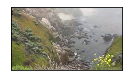

In [3]:
myplot(test)

In [4]:
test.max()

1.0

In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import cv2
import os

# Import plot utilities
from dl_utils import myplot
import os
import h5py
from rednet import REDNet

model_dir = "D:\OneDrive\Code\REDNet-TensorFlow\models"
model_name = "rednet_model.h5"
weights_name = "rednet_weights_5c5d2s.h5"
model_path = os.path.join(model_dir, model_name)
weights_path = os.path.join(model_dir, weights_name)
model, encoder, decoder = REDNet()
model.load_weights(weights_path)
model.summary()

optimizer = tf.keras.optimizers.Adam(lr=0.001)

# Compile Model and fit
model.compile(optimizer, 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mse'])

W0830 19:28:11.570875 10568 deprecation.py:506] From C:\Users\Patrick\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "REDNet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
conv4 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
conv5 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
deconv1 (Conv2DTranspose)    (None, 32, 32, 32)        9248

In [ ]:
test.shape

In [ ]:
img_out = model(test)

In [ ]:
img_out.dtype

In [ ]:
type(img_out)

In [ ]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    img = sess.run(img_out)


In [ ]:
type(img)

In [ ]:
img.max()

In [ ]:
img.shape

In [ ]:
y = img.reshape(img.shape[1:])

In [ ]:
y.shape

In [ ]:
y = (y-y.min())/(y.max()-y.min())

In [ ]:
plt.imshow(y)

In [5]:
n, m, c = test.shape[1:]
n_stride = n // 32
m_stride = m // 32

In [6]:
batch_dim = n_stride * m_stride
index = np.arange(batch_dim)

In [7]:
test_list = []
for i in range(batch_dim):
    ni = i % n_stride
    mi = i // n_stride
    nidx = ni*32
    midx = mi*32
    test_list.append(tf.cast(test[0, nidx:nidx+32, midx:midx+32, :], dtype=tf.float32))

In [8]:
test_batch = tf.stack(test_list)

In [9]:
test_batch.shape

TensorShape([Dimension(112), Dimension(32), Dimension(32), Dimension(3)])

In [10]:
test_pred = model(test_batch)

In [ ]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    img_pred = sess.run(test_pred)

In [ ]:
img_pred.shape

In [ ]:
type(img_pred)

In [ ]:
img_reshape = np.zeros(shape=test.shape[1:])

In [ ]:
for i in range(batch_dim):
    ni = i % n_stride
    mi = i // n_stride
    nidx = ni*32
    midx = mi*32
    img_reshape[nidx:nidx+32, midx:midx+32, :] = img_pred[i, :, :, :]

In [ ]:
img_reshape.shape

In [ ]:
img_reshape.ptp()

In [ ]:
img_reshape = (img_reshape-img_reshape.min())/(img_reshape.ptp())

In [ ]:
plt.imshow(img_reshape)

In [ ]:
plt.imshow(im)

In [ ]:
plt.imshow(test_batch[0])

In [ ]:
y0 = tf.expand_dims(test[0, :32, :32, :], 0)

In [ ]:
model(y0)

In [ ]:
y = model.predict(y0)

In [ ]:
with tf.Session as sess:
    im = sess.run(y)
plt.imshow(im)

In [ ]:
model.inputs[0]